In [1]:
#generate 25 minimal vc and pick the one with largest mass. Find sgw values afterward.

In [2]:
import numpy as np
import random

random_state=1300
np.random.seed(random_state)
n_exp = 100

A_sum_list = np.load('synthetic_A_sum_rho_1_true.npy').tolist()
P_sum_list = np.load('synthetic_P_sum_rho_1_true.npy').tolist()
Ratio_list = np.load('synthetic_Ratio_rho_1_true.npy').tolist()
A_matrices_tensor = np.load('synthetic_matrices_rho_1_true.npy')

random_indices = np.random.choice(n_exp, 25, replace=False)


A_sum_list_filtered_25 = [A_sum_list[i] for i in random_indices]
P_sum_list_filtered_25 = [P_sum_list[i] for i in random_indices]
Ratio_list_filtered_25 = [Ratio_list[i] for i in random_indices]
A_matrices_tensor_filtered_25 = A_matrices_tensor[random_indices]

# Save the filtered lists if needed
np.save('filtered_A_sum_rho_1_25mvc.npy', A_sum_list_filtered_25)
np.save('filtered_P_sum_rho_1_25mvc.npy', P_sum_list_filtered_25)
np.save('filtered_Ratio_rho_1_25mvc.npy', Ratio_list_filtered_25)
np.save('filtered_matrices_rho_1_25mvc.npy', A_matrices_tensor_filtered_25)

# Print to verify
# print("Filtered A_sum_list:", A_sum_list_filtered)
# print("Filtered P_sum_list:", P_sum_list_filtered)
# print("Filtered Ratio_list:", Ratio_list_filtered)
# print("Filtered A_matrices_tensor shape:", A_matrices_tensor_filtered.shape)


In [3]:
# Find the indices of the maximum value in P_sum_list
max_P_sum_value = np.max(P_sum_list_filtered_25)
max_indices = np.where(P_sum_list_filtered_25 == max_P_sum_value)[0]

# Among these indices, find the one with the smallest ratio in Ratio_list
#min_ratio_index = max_indices[np.argmin(Ratio_list[max_indices])]
min_ratio_index = random.choice(max_indices)

# Get the corresponding matrix A
corresponding_A_matrix = A_matrices_tensor_filtered_25[min_ratio_index]

# Find the nonzero locations of the matrix A
nonzero_indices = np.argwhere(corresponding_A_matrix > 0)

# Convert the nonzero indices to a set of tuples representing the vertex cover
tuples_set = set(tuple(idx+1) for idx in nonzero_indices)

# Print the minimum vertex cover set
print(f"The index of the largest P_sum_list value is: {min_ratio_index}")
print(f"The largest P_sum_list value is: {P_sum_list_filtered_25[min_ratio_index]}")
print("The corresponding matrix A is:")
print(corresponding_A_matrix)
print("The minimum vertex cover set (mvc) is:")
print(tuples_set)

The index of the largest P_sum_list value is: 17
The largest P_sum_list value is: 0.7499999999999969
The corresponding matrix A is:
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 0. 0. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
The minimum vertex cover set (mvc) is:
{(18, 17), (8, 9), (19, 18), (11, 14), (33, 38), (34, 3), (37, 8), (3, 15), (22, 28), (14, 24), (38, 9), (15, 25), (7, 21), (18, 30), (30, 4), (33, 15), (25, 11), (10, 31), (2, 27), (22, 5), (14, 1), (34, 16), (37, 21), (3, 28), (14, 37), (15, 2), (26, 11), (18, 7), (21, 18), (40, 31), (6, 38), (10, 8), (2, 40), (3, 5), (22, 18), (14, 14), (17, 25), (36, 38), (40, 8), (6, 15), (33, 5), (25, 1), (10, 21), (2, 17), (34, 6), (13, 32), (37, 11), (3, 18), (16, 37), (36, 15), (26, 1), (5, 27), (17, 38), (9, 34), (29, 12), (21, 8), (6, 28), (33, 18), (25, 14), (32, 22), (2, 30), (22, 8), (35, 27), (14, 4), (1, 34), (17, 15), (36, 28), (9, 11), (28, 24), (5, 40), (6, 5), (

In [4]:
#Function of sOT
def perform_sOT_log(G, a, b, eps, options):

    niter = options['niter_sOT']
    # tol   = options['tol_sOT']
    f     = options['f_init']
    g     = options['g_init']
    M     = options['penalty']

    # Err = np.array([[1, 1]])

    for q in range(niter):   
        f = np.minimum(eps * np.log(a) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=1)+ 10**-20) + f, M)
        g = np.minimum(eps * np.log(b) - eps * np.log(np.sum(np.exp((f[:, None] + g[None, :]  - G) / eps), axis=0)+ 10**-20) + g, M)

    P = np.exp((f[:, None] + g[None, :] - G) / eps)
    
    return P, f, g

In [5]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sp
import networkx as nx
import random

random_state=1
np.random.seed(random_state)

def generate_data(nsample, ratio):
    # Generate first ellipse
    s = np.random.uniform(size=(nsample, 3))
    x1 = np.zeros_like(s)
    x1[:, 0] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.cos(2 * np.pi * s[:, 2])
    )
    x1[:, 1] = 2 * np.sqrt(s[:, 0]) * np.sin(2 * np.pi * s[:, 1])
    x1[:, 2] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.sin(2 * np.pi * s[:, 2])
    )
    rot = 0.5 * np.sqrt(2) * np.array([[1, -1, 0], [1, 1, 0], [0, 0, 1]])
    x1 = x1.dot(rot)

    # Generate second circle
    s = np.random.uniform(size=(nsample, 3))
    x2 = np.zeros_like(s)
    x2[:, 0] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.cos(2 * np.pi * s[:, 2])
    )
    x2[:, 1] = np.sqrt(s[:, 0]) * np.sin(2 * np.pi * s[:, 1])
    x2[:, 2] = (
        np.sqrt(s[:, 0])
        * np.cos(2 * np.pi * s[:, 1])
        * np.sin(2 * np.pi * s[:, 2])
    )
    x2 = x2 + np.array([5.0, 0.0, 0.0])
    x = np.concatenate((x1, x2)) + np.array([0.0, 0.0, 8.0])

    # Generate second data drom translation
    y = np.concatenate((x1[:, :2], s[:, :2] + np.array([-4.0, 0.0])))
    angle = -np.pi / 4
    x[:nsample] = x[:nsample].dot(
        np.array(
            [
                [np.cos(angle), np.sin(angle), 0],
                [-np.sin(angle), np.cos(angle), 0],
                [0, 0, 1],
            ]
        )
    )
    y[nsample:] = (y[nsample:] - np.mean(y[nsample:], axis=0)).dot(
        np.array(
            [[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]
        )
    ) + np.mean(y[nsample:], axis=0)

    # Generate weights
    a, b = np.ones(x.shape[0]) / x.shape[0], np.ones(y.shape[0]) / y.shape[0]
    b[:n1], b[n1:] = (1 - ratio) * b[:n1], ratio * b[n1:]
    b = b / np.sum(b)
    return a, x, b, y

n1 = 20
ratio = 0.7
a, x, b, y = generate_data(n1, ratio)
x = np.array(x)
y = np.array(y)

C1 = sp.spatial.distance.cdist(x, x)
C2 = sp.spatial.distance.cdist(y, y)

n = C1.shape[0]
m = C2.shape[0]

51.3343948006165


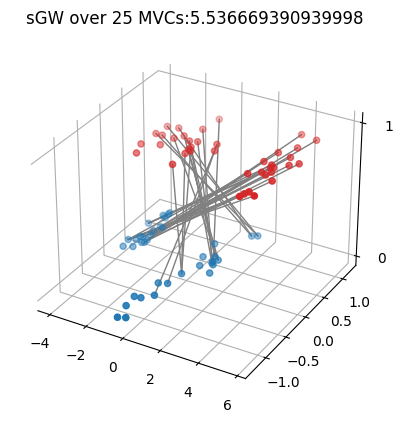

5.536669390939998


In [6]:
#####################

threshold = 1
gamma = 10
eps = 1e-2
eta = 1
verbose = False
nitermax = 20
#####################
a = np.array([1 / n] * n, dtype=float)
aa = a + 1e-1 * np.random.rand(n)
b = np.array([1 / m] * m, dtype=float)
bb = b + 1e-1 * np.random.rand(m)

aa = aa / np.linalg.norm((aa), ord=1)
bb = bb / np.linalg.norm((bb), ord=1)
tensor4 = (C1 - C2)**2     
      
P = np.outer(aa, bb) 
f = np.zeros(n)
g = np.zeros(m)
p_values = range(nitermax)
sgw_values = []

print(max(np.max(C1)**2,np.max(C2)**2))

for p in p_values:
        
    D = np.zeros((n, m)) 
    P_reshaped = P.reshape(1, 1, n, m) 
    D = np.sum(tensor4 * P_reshaped, axis=(-2, -1))
    sgw = np.sum(D * P)+gamma*(np.sum(a)+np.sum(b)-2*np.sum(P))+eps*np.sum(P * (np.log(P+10**(-20)*np.ones((n,m)))-np.ones((n,m))))
    sgw_values.append(sgw)
    
    D = 2*eta*D+eps*(eta-1)*np.log(P+10**(-20)*np.ones((n,m)))
                    
    for s, t in tuples_set:
        D[s-1, t-1] = np.inf
        
    options = {
    'niter_sOT': 10**5,
    'f_init': np.zeros(n),
    'g_init': np.zeros(m),
    'penalty': eta*gamma
    }
        
    P,f,g = perform_sOT_log(D, a, b, eps, options)

######################################################################################
#######################################################################################

def plot_mapping(P,X_1,X_2, thresh=None, linewidth=1, save_path=None):

    fig = plt.figure()
    
    ax = plt.axes(projection='3d') 
    ax.scatter3D(X_1[:,0], X_1[:,1], 0, c='tab:blue')
    ax.scatter3D(X_2[:,0], X_2[:,1], 1, c='tab:red')
    ax.set_title('sGW over 25 MVCs:' + str(sgw_values[19]))
    
    for i in range(P.shape[1]):
        if P[:,i].sum() < thresh: continue
        j = np.argmax(P[:,i])
        ax.plot3D([X_1[j,0], X_2[i,0]],[X_1[j,1], X_2[i,1]],[0,1],c='gray', linewidth=linewidth)
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_zticks([0, 1])
    
        
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
plot_mapping(P, y, x, thresh=0.00000001, save_path='synthetic_25mvc.png')
np.savetxt('synthetic_25mvc.csv', P, delimiter=',', fmt='%.10f')
print(sgw_values[19])

In [7]:
P_sum_list

[0.6250000000000038,
 0.6250000000000016,
 0.6000000000000094,
 0.6249999999999907,
 0.6250000000000067,
 0.6500000000000239,
 0.6750000000000193,
 0.6000000000000162,
 0.6249999999999951,
 0.600000000000013,
 0.7000000000000057,
 0.6750000000000035,
 0.6500000000000106,
 0.5750000000000073,
 0.6250000000000047,
 0.6000000000000023,
 0.6250000000000167,
 0.6750000000000098,
 0.6750000000000151,
 0.7250000000000136,
 0.700000000000018,
 0.6000000000000136,
 0.6250000000000002,
 0.6249999999999999,
 0.6249999999999984,
 0.6250000000000007,
 0.6000000000000071,
 0.7,
 0.6750000000000058,
 0.6000000000000023,
 0.6249999999999976,
 0.6750000000000035,
 0.7000000000000028,
 0.6500000000000011,
 0.5750000000000142,
 0.7250000000000136,
 0.6499999999999965,
 0.6999999999999911,
 0.6750000000000035,
 0.6000000000000024,
 0.6000000000000071,
 0.5750000000000149,
 0.6749999999999976,
 0.6000000000000024,
 0.6000000000000045,
 0.6249999999999998,
 0.6250000000000044,
 0.6500000000000048,
 0.700000

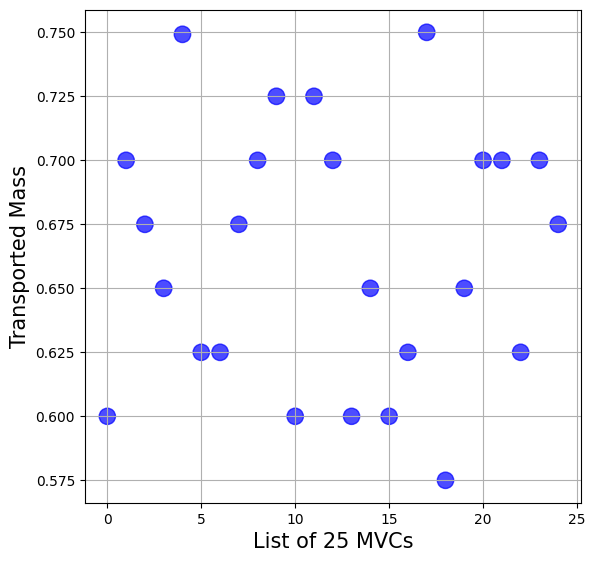

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data
A_sum_list = np.load('filtered_A_sum_rho_1_25mvc.npy')
P_sum_list = np.load('filtered_P_sum_rho_1_25mvc.npy')

# Normalizing the size for better visualization
sizes = np.array(A_sum_list) * 0.1  # Scale factor for visibility, adjust as needed

# Set a single color for all points
single_color = 'blue'  # You can change this to any color you prefer

plt.figure(figsize=(6.4, 6.4))
plt.scatter(range(len(P_sum_list)), P_sum_list, s=sizes, c=single_color, alpha=0.7)
plt.xlabel('List of 25 MVCs', fontsize=15)
plt.ylabel('Transported Mass', fontsize=15)
plt.grid(True)
plt.savefig('synthetic_P_sum_25mvc.png', dpi=300, bbox_inches='tight')
plt.show()

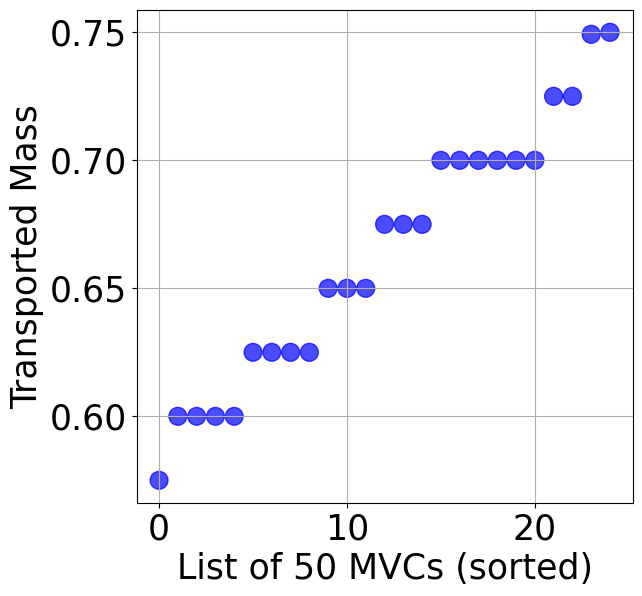

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Data
A_sum_list = np.load('filtered_A_sum_rho_1_25mvc.npy')
P_sum_list = np.load('filtered_P_sum_rho_1_25mvc.npy')

# Normalizing the size for better visualization
sizes = np.array(A_sum_list) * 0.12  # Scale factor for visibility, adjust as needed

# Sort P_sum_list and get sorted indices
sorted_indices = np.argsort(P_sum_list)
sorted_P_sum_list = P_sum_list[sorted_indices]
sorted_sizes = sizes[sorted_indices]

# Set a single color for all points
single_color = 'blue'  # You can change this to any color you prefer

plt.figure(figsize=(6.4, 6.4))
plt.scatter(range(len(sorted_P_sum_list)), sorted_P_sum_list, s=sorted_sizes, c=single_color, alpha=0.7)
plt.xlabel('List of 50 MVCs (sorted)', fontsize=25)
plt.ylabel('Transported Mass', fontsize=25)
plt.tick_params(axis='x', labelsize=25)  # Adjust the font size as needed
plt.tick_params(axis='y', labelsize=25)
plt.grid(True)
plt.savefig('synthetic_P_sum_all_sorted.png', dpi=300, bbox_inches='tight')
plt.show()
